In [1]:

import xtrack as xt
import xobjects as xo
import xpart as xp

import ducktrack as dtk
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from tqdm import tqdm
from scipy import constants 
import os

# Generalized variables
textwidth_cm = 16.50764  # Text width in cm
aspect_ratio = 0.618     # Aspect ratio (height/width) using the golden ratio

# Font sizes
label_fontsize = 12
legend_fontsize = 12
tick_fontsize = 10
colorbar_label_fontsize = 12
colorbar_tick_fontsize = 10
offset_text_fontsize = 12
tick_fontsize = 10
errorbar_capsize = 5

# Convert text width from cm to inches
textwidth_in = textwidth_cm / 2.54

# Calculate figure size based on text width and aspect ratio
fig_width = textwidth_in
fig_height = textwidth_in * aspect_ratio

save_dir = '/home/pkruyt/cernbox/figures_thesis/imperfections_magnetic_field/'

In [2]:
# copyright ############################### #
# This file is part of the Xtrack Package.  #
# Copyright (c) CERN, 2021.                 #
# ######################################### #


# beta_rel = 0.305
beta_rel = 0.106
# gamma = 1.050
gamma = 1.006
mass0=938.27208816*1e6 #ev/c^2
p0c = mass0*beta_rel*gamma #eV/c

current=2.4
cooler_length = 1.5 # m cooler length
radius_e_beam=25*1e-3
temp_perp = 100*1e-3 # <E> [eV] = kb*T
temp_long =  1*1e-3 # <E> [eV]
magnetic_field = 0.060 # T for LEIR
Z=1


c = constants.c   


circumference = 182.43280000000 #m
T_per_turn = circumference/(c*beta_rel)
ms_per_turn = 1000*T_per_turn


beta_x=10 
beta_y=4
emittance=10*1e-6

arc=dtk.LinearTransferMatrix(Q_x=5.38518956965, Q_y=5.36921653748,
                            beta_x_0=beta_x, beta_x_1=beta_x,
                            beta_y_0=beta_y,  beta_y_1=beta_y,
                            alpha_x_0=0,   alpha_x_1=0,
                            alpha_y_0=0,   alpha_y_1=0,
                            disp_x_0=0,disp_x_1=0,
                            disp_y_0=0,    disp_y_1=0,
                            beta_s=1*1e40,
                            Q_s=0,
                            chroma_x=0.0, chroma_y=0
                                           
                 )

num_particles=int(1e4)

#x=np.random.normal(0,np.sqrt(5*emittance) ,num_particles),
#px=np.random.normal(0, np.sqrt(emittance/5), num_particles),
#x=np.linspace(1*1e-3, 20*1e-3, num_particles),
#px=np.random.uniform(0, 0, num_particles),

particles = xp.Particles(
        
        mass0=mass0,
        p0c=p0c,
        x=np.random.normal(0,1e-40 ,num_particles),
        px=np.random.normal(0, np.sqrt(emittance/beta_x), num_particles),
        y=np.random.normal(0, 1e-40, num_particles),
        py=np.random.normal(0, 1e-40, num_particles),
        delta=np.random.normal(0, 1e-40, num_particles),
        zeta=np.random.normal(0, 1e-40, num_particles))

particles0=particles.copy()
particles1=particles.copy()


In [3]:
#xp_cooler=1e-3

magnetic_field_ratio=1e-3

cooler = xt.ElectronCooler(current=current, length=cooler_length, radius_e_beam=radius_e_beam,
                                        temp_perp=temp_perp, temp_long=temp_long,
                                        magnetic_field=magnetic_field,magnetic_field_ratio=magnetic_field_ratio,
                                        space_charge_factor=0,
                                        offset_px=0)

line = xt.Line(elements=[cooler])
#line.particle_ref = particle_ref
line.build_tracker()

# Start internal logging for the electron cooler
record = line.start_internal_logging_for_elements_of_type(
    xt.ElectronCooler, capacity=10000)


cooler0 = xt.ElectronCooler(current=current, length=cooler_length, radius_e_beam=radius_e_beam,
                                        temp_perp=temp_perp, temp_long=temp_long,
                                        magnetic_field=magnetic_field,magnetic_field_ratio=0,
                                        space_charge_factor=0,
                                        offset_px=0)

line0 = xt.Line(elements=[cooler0])
#line.particle_ref = particle_ref
line0.build_tracker()

# Start internal logging for the electron cooler
record0 = line0.start_internal_logging_for_elements_of_type(
    xt.ElectronCooler, capacity=10000)


line_series=xt.Line()

num_coolers=int(1e4)

for i in range(num_coolers):
    angle=np.random.normal(0,magnetic_field_ratio,1)
    #angle=np.random.uniform(-B_ratio,B_ratio,1)
    #print('angle:',angle)
    cooler_tiny = xt.ElectronCooler(current=current, length=cooler_length, radius_e_beam=radius_e_beam,
                                         temp_perp=temp_perp, temp_long=temp_long,
                                         magnetic_field=magnetic_field,magnetic_field_ratio=0,
                                         space_charge_factor=0,
                                         offset_px=angle)
    
    
    #coolers.append(cooler_tiny)
    line_series.append_element(name=f'cooler{i}',element=cooler_tiny)

line_series.build_tracker()

record_series = line_series.start_internal_logging_for_elements_of_type(
    xt.ElectronCooler, capacity=num_particles*num_coolers)

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


In [4]:
num_turns=int(1)

x=[]
px=[]
action = []
force = []
force_old = []
force_0 = []


for i in tqdm(range(num_turns)):
    x.append(particles.x)
    px.append(particles.px)
    
    action_temp = (particles.x**2/beta_x + beta_x*particles.px**2) #Joule sec
    action.append(action_temp)    
   
    force_temp=[]        
    

    line.track(particles)
    force = record.Fx
    force_old.append(force)    
    

    line0.track(particles0)
    force_x0 = record0.Fx
    force_0.append(force_x0)

    line_series.track(particles1)
    fx=record_series.Fx
    fx = fx.reshape(num_coolers, -1)
        
        
    force_temp=np.array(force_temp)
    force=force_temp.mean(axis=0)  
    force=fx.mean(axis=0)
    #force=np.squeeze(force)

x = np.array(x)
px = np.array(px)
action = np.array(action)
force = np.array(force).flatten().flatten()
force_old = np.array(force_old).flatten().flatten()
force_0 = np.array(force_0).flatten().flatten()


px_tot = p0c * px
beta_diff = px_tot / (mass0 * gamma)
v_diff = beta_diff * c

v_diff=v_diff.flatten().flatten()

sorted_indices = np.argsort(v_diff)
v_diff_sorted = v_diff[sorted_indices]
force_0_sorted = force_0[sorted_indices]
force_sorted = force[sorted_indices]
force_old_sorted = force_old[sorted_indices]

Fx_series_sorted= force[sorted_indices]

  0%|          | 0/1 [00:00<?, ?it/s]/tmp/pkruyt/ipykernel_443352/3584963818.py:36: RuntimeWarning: Mean of empty slice.
  force=force_temp.mean(axis=0)
/home/pkruyt/miniforge3/envs/xsuite2025/lib/python3.13/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 1/1 [00:16<00:00, 16.83s/it]


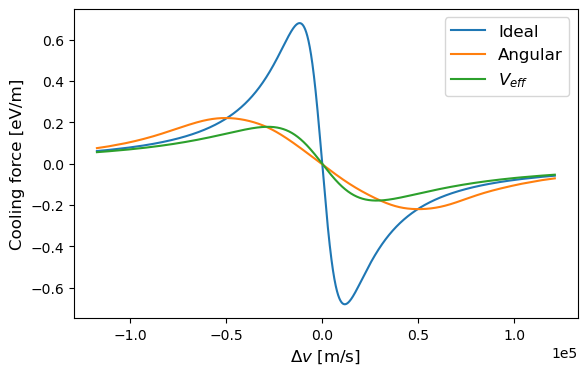

In [5]:
# Create the figure with the calculated dimensions
plt.figure(figsize=(fig_width, fig_height))

# Plot the data
plt.plot(v_diff_sorted, force_0_sorted, label='Ideal')
plt.plot(v_diff_sorted, force_sorted, label='Angular')
plt.plot(v_diff_sorted, force_old_sorted, label='$V_{eff}$')

# Set labels with appropriate font size
plt.xlabel('$\\Delta v$ [m/s]', fontsize=label_fontsize)
plt.ylabel('Cooling force [eV/m]', fontsize=label_fontsize)

# Set tick label size
plt.xticks(fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)

# Add legend with defined font size
plt.legend(fontsize=legend_fontsize)

# Use scientific notation for the x-axis
plt.ticklabel_format(axis='x', style='sci', scilimits=(-2, 2))


image_name = f'ad_imperfections={magnetic_field_ratio}.png'
save_location = os.path.join(save_dir, image_name)
plt.savefig(save_location, dpi=300, bbox_inches='tight')
plt.show()


In [6]:
# plt.scatter(px,force_0)